# DeepCalc - Handwritten digit calculator

Learn how to add and subtract handwritten numbers.

The goal is to show a toy example how to write reusable modules (such as image recognizer) with Gluon and how to combine them together.

Additional material to talk "Differentiable programming in Python and Gluon for (not only medical) image analysis." by Jan Margeta on PyCon SK 2018

- https://github.com/jmargeta/PyConSK2018
- https://twitter.com/jmargeta/
- https://kardio.me/


![deep calc](./media/deep_calc.png)

In [1]:
%pylab inline

import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon import nn
from tqdm import trange

ctx = mx.cpu()

Populating the interactive namespace from numpy and matplotlib


# Make a dataset

Our dataset will diverge from traditional

In [2]:
class MNISTCalcDataset(gluon.data.Dataset):
    def __init__(self, mnist):
        self.mnist = mnist
        self.indices = np.random.permutation(len(self.mnist))

    def __getitem__(self, idx):
        x0, label0 = self.mnist[int(self.indices[idx])]
        x1, label1 = self.mnist[int(self.indices[idx + 1])]
        plus = np.float32(label0 + label1)
        minus = np.float32(label0 - label1)
        return (x0, x1), (plus, minus)

    def __len__(self):
        return len(self.mnist) - 1

In [3]:
def mnist_transform(data, label):
    """Transform each sample.
    
    Samples should have shape channels x height x width.
    This will allow us to use convolutional layers directly.
    In case of MNIST and other grayscale images, the channels dimension is just 1.
    """
    data = data.astype(np.float32)/255
    return nd.transpose(data, (2, 0, 1)), label

# Digit recognition training and testing datasets
mnist_train_data = mx.gluon.data.vision.MNIST(train=True, transform=mnist_transform)
mnist_test_data = mx.gluon.data.vision.MNIST(train=False, transform=mnist_transform)   

train_mnist_data = gluon.data.DataLoader(mnist_train_data, batch_size=16, shuffle=True)
test_mnist_data = gluon.data.DataLoader(mnist_test_data, batch_size=16, shuffle=True)


# DeepCalc training and testing datasets
test_dataset = MNISTCalcDataset(mnist_test_data)
train_dataset = MNISTCalcDataset(mnist_train_data)

train_data = mx.gluon.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data = mx.gluon.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

## Visualize samples from the dataset

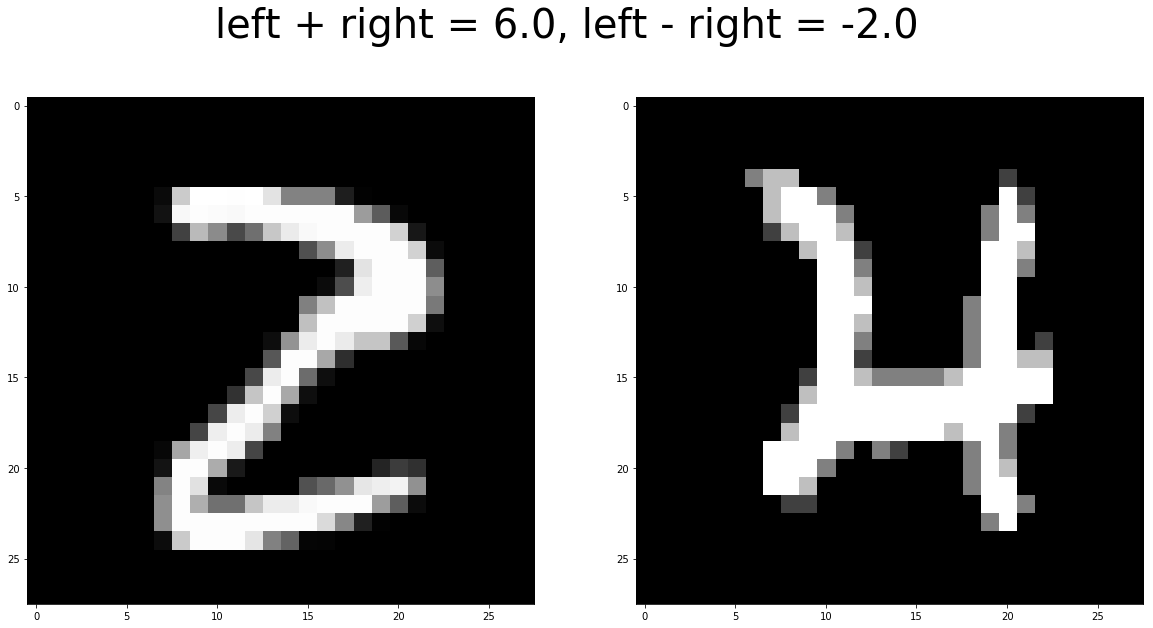

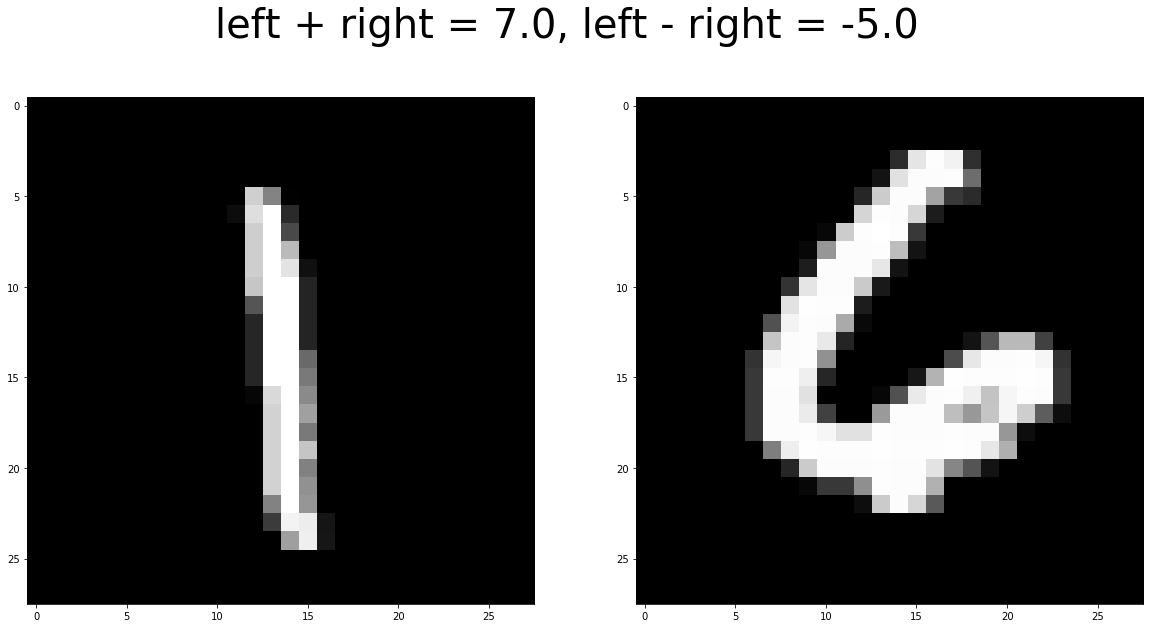

In [4]:
def visualize_sample(left, right, plus, minus):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(left[0].asnumpy(), cmap='gray')
    ax[1].imshow(right[0].asnumpy(), cmap='gray')
    fig.suptitle(f'left + right = {plus:0.1f}, left - right = {minus:0.1f}', fontsize=40);

ims, ops = train_dataset[0]
visualize_sample(*ims, *ops);

ims, ops = train_dataset[13]
visualize_sample(*ims, *ops);

# Define loss function

In some sense the loss function can be seen as problem definition.
This is what drives the parameters towards the solution.

In [5]:
operation_loss = gluon.loss.L2Loss()
digit_recognition_loss = gluon.loss.SoftmaxCrossEntropyLoss()

# custom loss would be simple, e.g.:
# def operation_loss(predicted, real):
#    return ((predicted - real) ** 2).sum(axis=1)

# Define models

## Digit recognition model
- a relatively simple image recognition model with 10 output classes

In [6]:
class LeNet(nn.HybridSequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.add(nn.Conv2D(6, kernel_size=(5, 5), activation='relu'))
            self.add(nn.MaxPool2D(pool_size=(2, 2)))
            self.add(nn.Conv2D(16, kernel_size=(5, 5), activation='relu'))
            self.add(nn.MaxPool2D(pool_size=(2, 2)))
            self.add(nn.Flatten())
            self.add(nn.Dense(120, activation='relu'))
            self.add(nn.Dense(84, activation='relu'))
            self.add(nn.Dense(10))

In [7]:
class DeepOp(nn.HybridBlock):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.preprocess = nn.HybridSequential(prefix='preprocess_')
            with self.preprocess.name_scope():
                self.preprocess.add(nn.Flatten())
                self.preprocess.add(nn.Dense(100, activation='relu'))
            self.d0 = nn.Dense(100, activation='relu')
            self.d1 = nn.Dense(100, activation='relu')
            self.out_operation = nn.Dense(1)
        
    def hybrid_forward(self, F, x, y):
        x = self.preprocess(x)
        y = self.preprocess(y)

        features = F.concat(x, y, dim=1)        
        features = self.d0(features)
        features = self.d1(features)
        return self.out_operation(features)

In [8]:
class DeepCalc(nn.HybridBlock):
    def __init__(self):
        super().__init__()
        self.digit_recognizer = LeNet(prefix='digit_recognizer_')
        self.plus_op = DeepOp(prefix='plus_op_')
        self.minus_op = DeepOp(prefix='minus_op_')
        
    def hybrid_forward(self, F, x, y):
        digit_x = F.softmax(self.digit_recognizer(x))
        digit_y = F.softmax(self.digit_recognizer(y))
        return (
            self.plus_op(digit_x, digit_y),
            self.minus_op(digit_x, digit_y)
        )

In [9]:
calc = DeepCalc()
calc.collect_params().initialize(mx.init.Normal(sigma=0.05), ctx=ctx)

# Predictions before any training

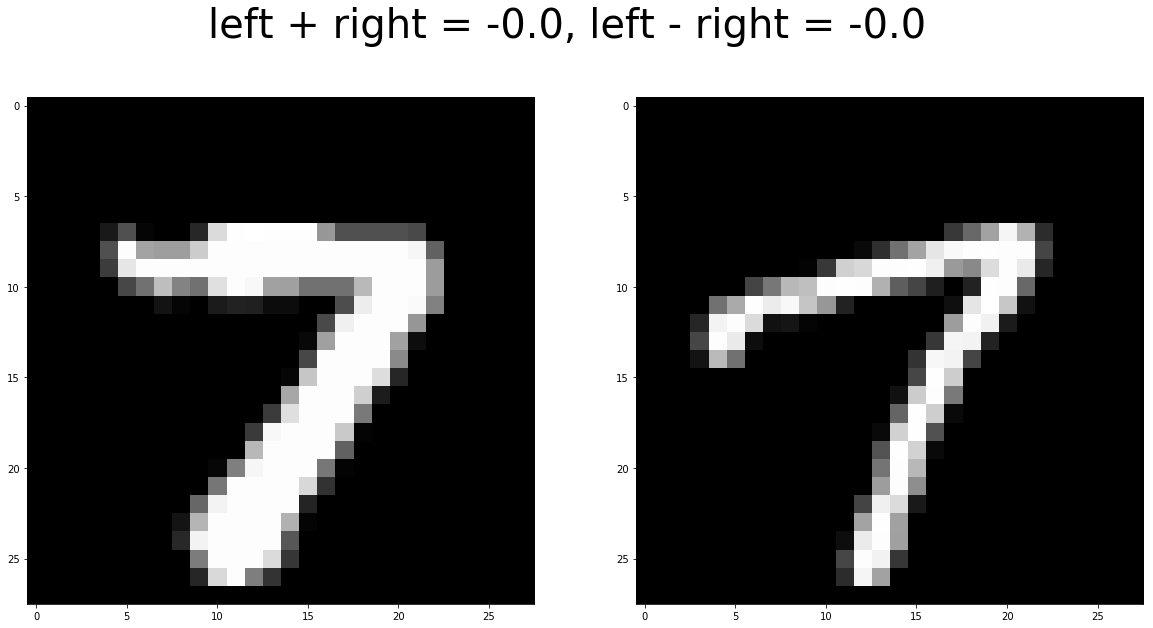

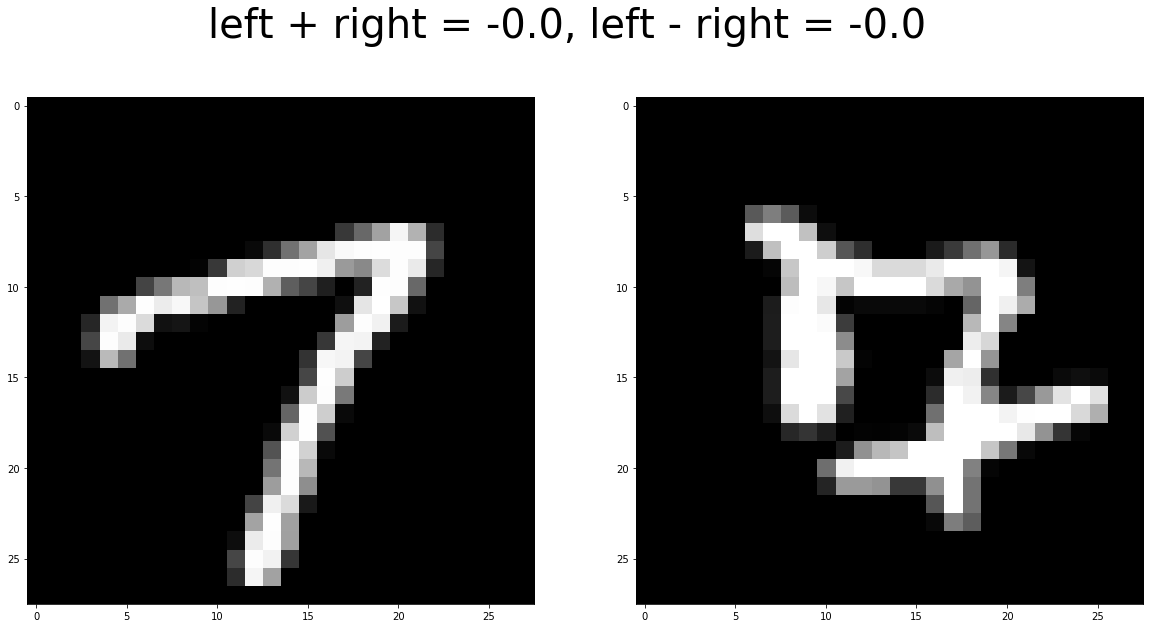

In [10]:
(left, right), (plus_label, minus_label) = next(iter(test_data))

plus_pred, minus_pred = calc(left.as_in_context(ctx), right.as_in_context(ctx))

idx = 0; visualize_sample(left[idx], right[idx], plus_pred[idx].asscalar(), minus_pred[idx].asscalar())
idx = 1; visualize_sample(left[idx], right[idx], plus_pred[idx].asscalar(), minus_pred[idx].asscalar())

# Train the model

The calculations above are simply incorrect. Let's train the model.

We could try to train all model parameters, end-to-end by using: ```trainer = gluon.Trainer(calc.collect_params(), 'adam')``` at the same time.

Yet, this would not converge really well.

Instead, we train DeepCalc in two steps. First, the digit recognizer and then the calculation operations.

## Train the digit recognizer first

In [11]:
from tqdm import tqdm

In [12]:
num_epochs = 1

digit_pred_losses = []

trainer = gluon.Trainer(calc.digit_recognizer.collect_params(), 'adam')

epoch_iter = trange(num_epochs)
for epoch in epoch_iter:
    for batch, (ims, labels) in enumerate(train_mnist_data):
        with mx.autograd.record():
            digit_pred = calc.digit_recognizer(ims.as_in_context(ctx))
            loss = digit_recognition_loss(digit_pred, labels.astype(np.float32).as_in_context(ctx))

        # compute gradients and optimize model parameters
        loss.backward()
        trainer.step(ims.shape[0])
        
        mean_loss = loss.mean().asscalar()
        digit_pred_losses.append(mean_loss)

        epoch_iter.set_description(f'EPOCH {epoch} ({batch + 1:02d}/{len(train_mnist_data):02d})')
        epoch_iter.set_postfix(loss=mean_loss, batch=batch)

EPOCH 0 (3750/3750): 100%|██████████| 1/1 [00:39<00:00, 39.82s/it, batch=3.75e+03, loss=0.0294]


Text(0.5,1,'Digit recognizer loss')

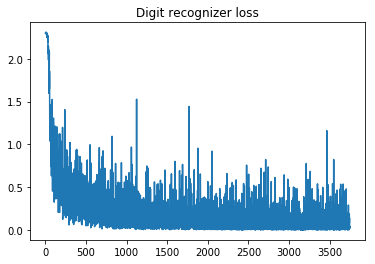

In [13]:
plt.plot(digit_pred_losses)
plt.title('Digit recognizer loss')

## Train calculator operations

In [14]:
calc_losses = []

not_digit_recognizer_regex = '(?!digit_recognizer)'
trainer = gluon.Trainer(calc.collect_params(select=not_digit_recognizer_regex), 'adam')

epoch_iter = trange(num_epochs)
for epoch in epoch_iter:
    for batch, ((left, right), (addition_label, subtraction_label)) in enumerate(train_data):
        with mx.autograd.record():
            addition_pred, subtraction_pred = calc(left.as_in_context(ctx), right.as_in_context(ctx))
            addition_loss = operation_loss(addition_pred, addition_label.as_in_context(ctx))
            subtraction_loss = operation_loss(subtraction_pred, subtraction_label.as_in_context(ctx))
            total_loss = addition_loss + subtraction_loss

        # compute gradients and optimize model parameters
        total_loss.backward()
        
        trainer.step(left.shape[0])
        total_loss_mean = total_loss.mean().asscalar()
        calc_losses.append(total_loss_mean)

        epoch_iter.set_description(f'EPOCH {epoch} ({batch + 1:02d}/{len(train_data):02d})')
        epoch_iter.set_postfix(loss=total_loss_mean, batch=batch)

        # no need to do all batches in this example
        if batch > 2000:
            break

EPOCH 0 (2002/3750): 100%|██████████| 1/1 [00:50<00:00, 50.38s/it, batch=2e+03, loss=0.0558]


Text(0.5,1,'Calculator operations loss')

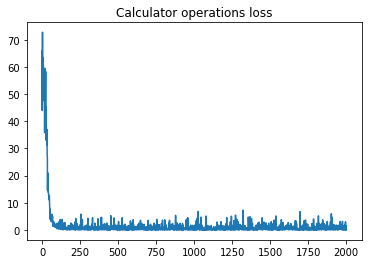

In [15]:
plt.plot(calc_losses)
plt.title('Calculator operations loss')

In [16]:
plus_pred, minus_pred = calc(left.as_in_context(ctx), right.as_in_context(ctx))

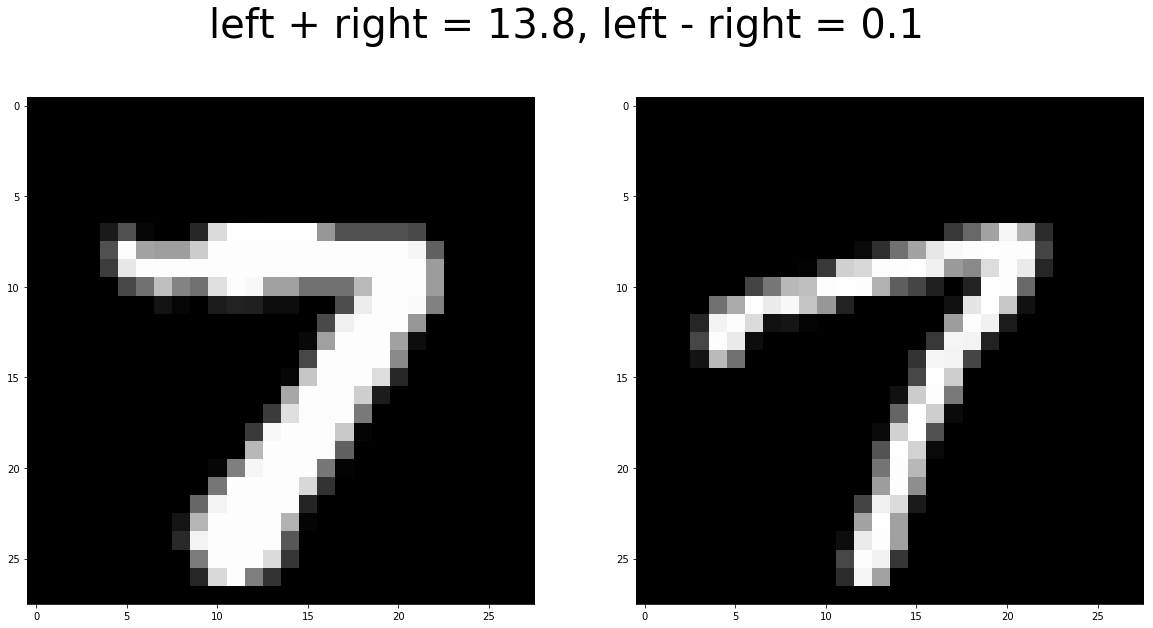

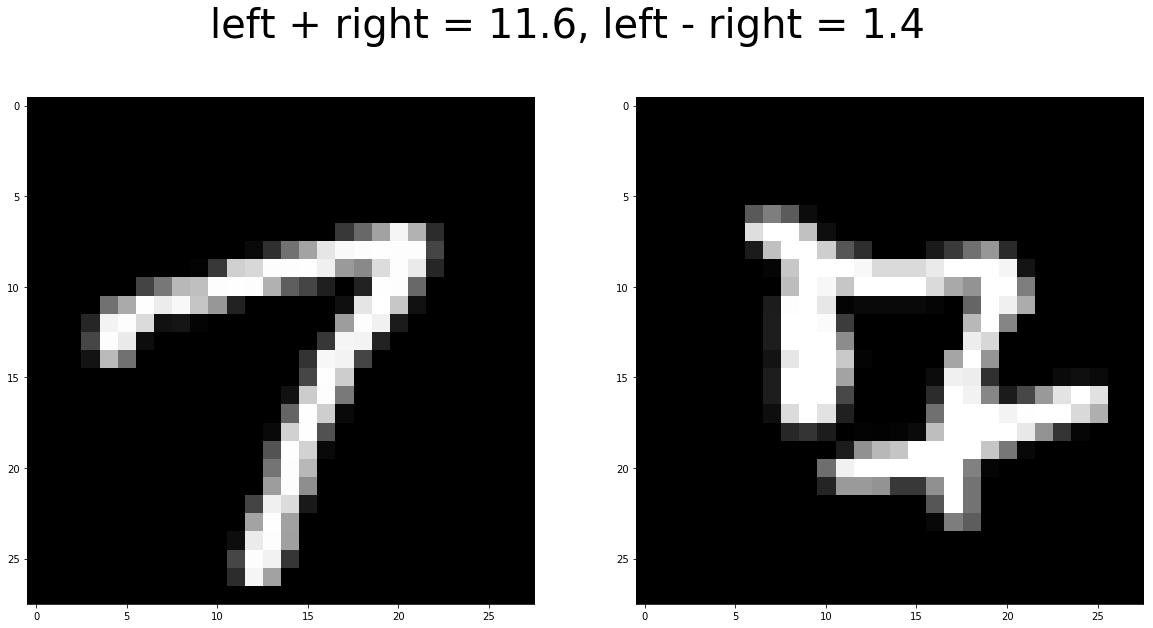

In [17]:
(left, right), (plus_label, minus_label) = next(iter(test_data))

plus_pred, minus_pred = calc(left.as_in_context(ctx), right.as_in_context(ctx))

idx = 0; visualize_sample(left[idx], right[idx], plus_pred[idx].asscalar(), minus_pred[idx].asscalar())
idx = 1; visualize_sample(left[idx], right[idx], plus_pred[idx].asscalar(), minus_pred[idx].asscalar())

close enough...

# Plot the whole computational graph

In [18]:
left = mx.sym.Variable('left')
right = mx.sym.Variable('right')

plus, minus = calc(left, right)

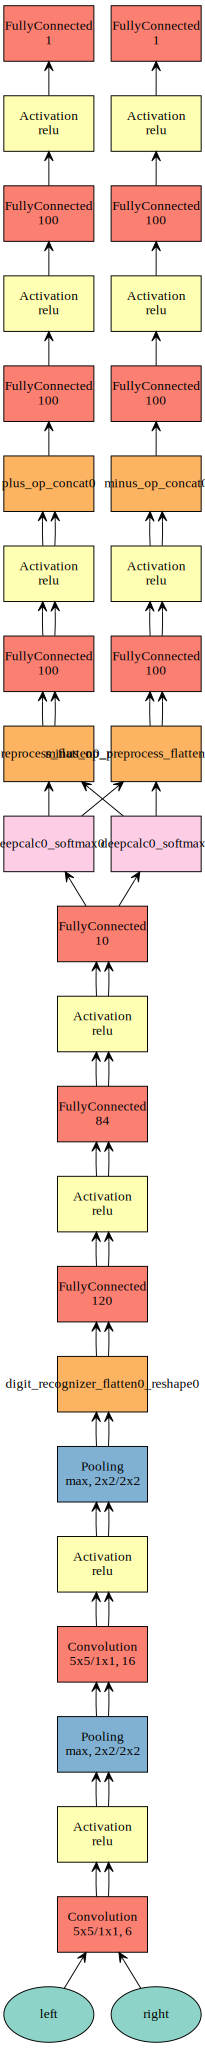

In [19]:
mx.visualization.plot_network(mx.sym.Group([plus, minus]), title='DeepCalc')